<a id="toc"></a>

## <p style="background-color:#CAFF70; font-family:monospace; color:#2D2727; font-size:150%; text-align:center; border-radius:10px 10px;">Nortwind Data Analysis</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.io.sql as sqlio
import psycopg2 as ps

In [2]:
conn = ps.connect(dbname="Northwind",
                  user="postgres",
                  password="12345",
                  port = "5432")

In [3]:
sql1 = """WITH DATA AS (
SELECT order_date,
	order_id,
	CASE WHEN order_date >= '1996-07-04' AND order_date <'1997-01-01' THEN '1996-1997'
	WHEN order_date >= '1997-01-01' AND order_date <'1998-01-01' THEN '1997-1998'
	WHEN order_date >= '1998-01-01' AND order_date <'1998-05-06' THEN '1998-1998'
	END AS years
	FROM orders
)
SELECT 
years,
COUNT(order_id) OVER (PARTITION BY years) AS orders_by_years
FROM DATA"""

In [4]:
df1 = sqlio.read_sql_query(sql1,conn)
df1

C:\Users\User\AppData\Local\Temp\ipykernel_2524\2597695752.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql1,conn)


,years,orders_by_years
0,1996-1997,152
1,1996-1997,152
2,1996-1997,152
3,1996-1997,152
4,1996-1997,152
...,...,...
825,1998-1998,266
826,None,4
827,None,4
828,None,4


In [5]:
df.shape

(830, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   years            826 non-null    object
 1   orders_by_years  830 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.1+ KB


In [7]:
df = df.dropna(axis=0)

In [8]:
order_by_years = df.groupby("years")["orders_by_years"].count()

In [73]:
df1 = pd.DataFrame(order_by_years)
df1

,orders_by_years
years,
1996-1997,152
1997-1998,408
1998-1998,266


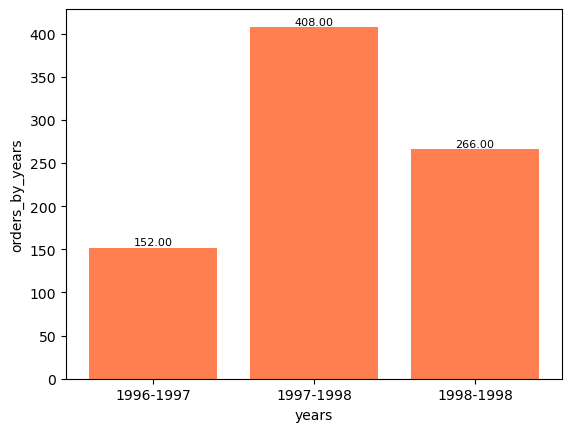

In [79]:
g = sns.barplot(data=df, x=df.index, y=df.orders_by_years);
bars = plt.bar(df1.index, df1['orders_by_years'], color='coral')
for bar, price in zip(bars, df1['orders_by_years']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{price:.2f}', 
             ha='center', va='bottom', fontsize=8, rotation=0, color='black')

In [12]:
sql2 = """SELECT
o.employee_id,
CONCAT(e.first_name, ' ', e.last_name) AS employee_full_name,
e.title,
COUNT(o.order_id) AS order_count
FROM orders as o
LEFT JOIN employees as e ON e.employee_id=o.employee_id
GROUP BY 1,2,3"""

In [85]:
df2 = sqlio.read_sql_query(sql2,conn)
df2 = df2.sort_values(by="order_count", ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_2524\378998899.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = sqlio.read_sql_query(sql2,conn)


Text(0, 0.5, 'Employee Name')

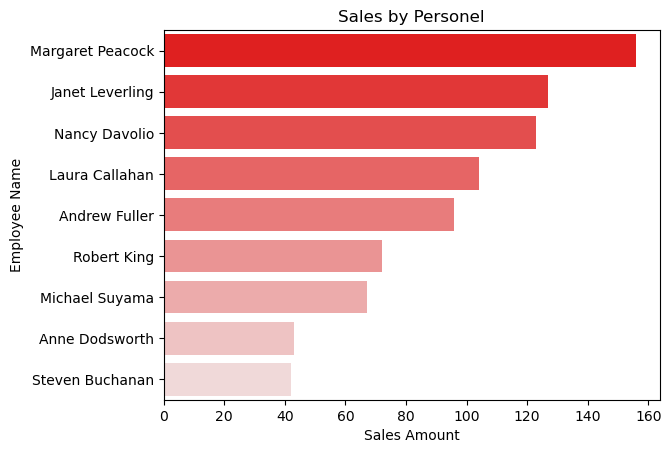

In [89]:
sns.despine(left=True)
colors = sns.light_palette("red", n_colors=10, reverse=True)
sns.barplot(data=df2, x=df2.order_count, y=df2.employee_full_name, orient = "h", palette=colors)

plt.title('Sales by Personel')
plt.xlabel('Sales Amount')
plt.ylabel('Employee Name')

In [3]:
sql3 = """WITH discount AS(
	SELECT
	od.product_id,
	pr.product_name,
	ROUND(LEAD(od.unit_price) OVER (PARTITION BY pr.product_name ORDER BY o.order_date)::NUMERIC, 2) AS current_price,
	ROUND(LAG(od.unit_price) OVER (PARTITION BY pr.product_name ORDER BY o.order_date)::NUMERIC, 2) AS old_price
	FROM products AS pr
	LEFT JOIN order_details AS od ON pr.product_id=od.product_id
	LEFT JOIN orders AS o ON o.order_id=od.order_id
)
SELECT
d.product_id,
d.product_name,
d.current_price,
d.old_price,
ROUND((d.current_price - d.old_price)/d.old_price*100) AS price_change_percentage
FROM discount AS d
INNER JOIN order_details AS od
ON d.product_id = od.product_id
WHERE d.current_price != d.old_price
GROUP BY 1,2,3,4"""

In [4]:
df3 = sqlio.read_sql_query(sql3,conn)
df3

C:\Users\User\AppData\Local\Temp\ipykernel_34108\146072055.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = sqlio.read_sql_query(sql3,conn)


,product_id,product_name,current_price,old_price,price_change_percentage
0,6,Grandma's Boysenberry Spread,25.00,20.0,25.0
1,58,Escargots de Bourgogne,13.25,10.6,25.0
2,62,Tarte au sucre,49.30,39.4,25.0
3,53,Perth Pasties,32.80,26.2,25.0
4,47,Zaanse koeken,9.50,7.6,25.0
...,...,...,...,...,...
75,14,Tofu,23.25,18.6,25.0
76,18,Carnarvon Tigers,62.50,50.0,25.0
77,33,Geitost,2.50,2.0,25.0
78,5,Chef Anton's Gumbo Mix,21.35,17.0,26.0


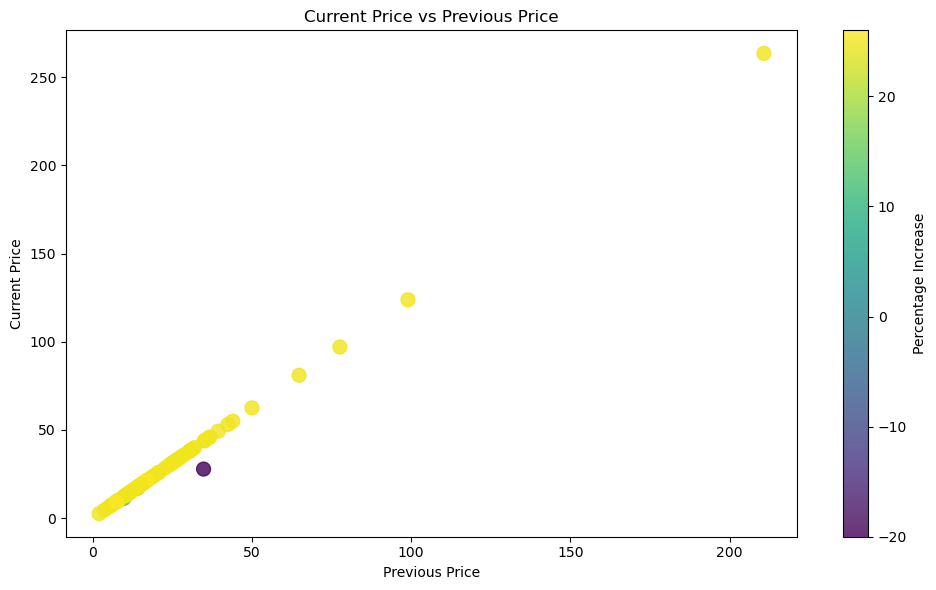

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(df3['old_price'], df3['current_price'], c=df3['price_change_percentage'], cmap='viridis', s=100, alpha=0.8)
plt.xlabel('Previous Price')
plt.ylabel('Current Price')
plt.title('Current Price vs Previous Price')
plt.colorbar(label='Percentage Increase')
plt.tight_layout()
plt.show()

In [21]:
sql4 = """SELECT
ct.category_name,
SUM(pr.unit_in_stock) AS unit_stock
FROM products AS pr
LEFT JOIN categories AS ct ON ct.category_id=pr.category_id
GROUP BY 1
"""

In [22]:
df4 = sqlio.read_sql_query(sql4,conn)
df4

C:\Users\User\AppData\Local\Temp\ipykernel_2524\702295488.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = sqlio.read_sql_query(sql4,conn)


,category_name,unit_stock
0,Beverages,559
1,Produce,100
2,Condiments,507
3,Grains/Cereals,308
4,Meat/Poultry,165
5,Confections,386
6,Dairy Products,393
7,Seafood,701


In [30]:
categories = df4["category_name"]

In [38]:
labels = df4.category_name.tolist()
sizes = df4.unit_stock.tolist()

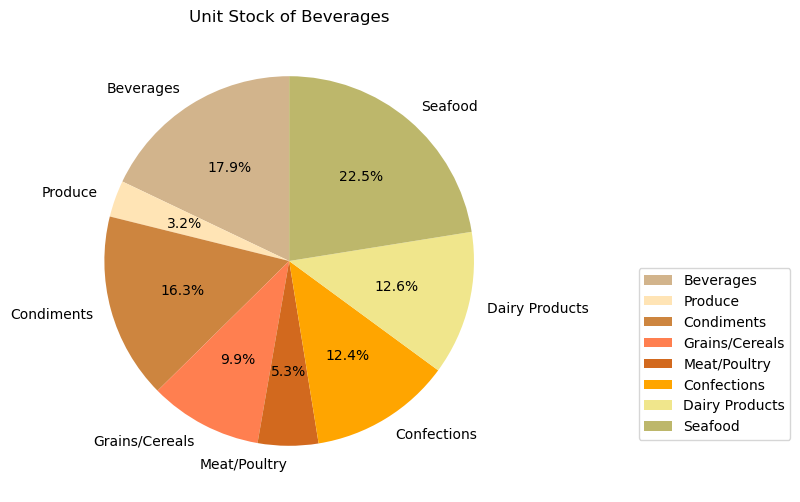

In [71]:
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tan', 'moccasin', 'peru', 'coral', 'chocolate', 'orange', 'khaki', 'darkkhaki'])
plt.title('Unit Stock of Beverages')
plt.legend(labels, bbox_to_anchor=(1.6, 0.5))

plt.show()

In [90]:
sql5 = """SELECT
product_name,
unit_price
FROM products
WHERE unit_price BETWEEN 20 AND 60
ORDER BY unit_price DESC"""

In [91]:
df5 = sqlio.read_sql_query(sql5,conn)
df5

C:\Users\User\AppData\Local\Temp\ipykernel_2524\3333582910.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = sqlio.read_sql_query(sql5,conn)


,product_name,unit_price
0,Raclette Courdavault,55.00
1,Manjimup Dried Apples,53.00
2,Tarte au sucre,49.30
3,Ipoh Coffee,46.00
4,Rössle Sauerkraut,45.60
5,Vegie-spread,43.90
6,Schoggi Schokolade,43.90
7,Northwoods Cranberry Sauce,40.00
8,Alice Mutton,39.00
9,Gnocchi di nonna Alice,38.00


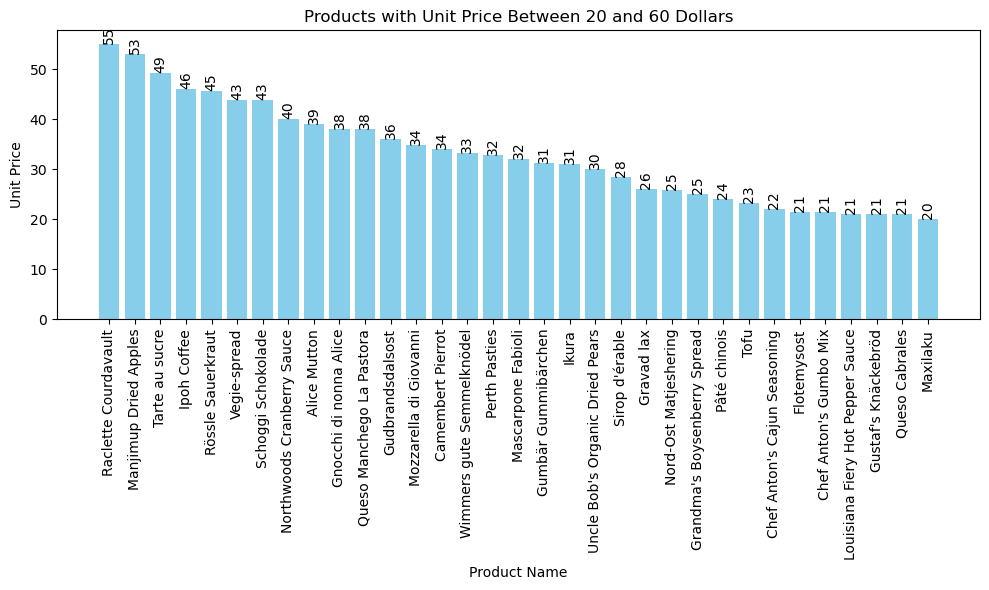

In [96]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df5['product_name'], df5['unit_price'], color='skyblue')
plt.xlabel('Product Name')
plt.ylabel('Unit Price')
plt.title('Products with Unit Price Between 20 and 60 Dollars')
plt.xticks(rotation=90)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, rotation=90)

plt.tight_layout()
plt.show()